In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal
from libpysal import cg
import seaborn as sns
import contextily
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pointpats import centrography
from matplotlib.patches import Ellipse
from shapely.geometry import shape, Polygon, MultiPolygon
from descartes import PolygonPatch

## Leer Datos


In [2]:
db = pd.read_csv('./data/hurto_a_residencia.csv')

In [3]:
db.head()

fecha_hecho  cantidad   latitud   longitud    sexo  edad  \
0  2017-01-01T13:51:00.000-05:00       1.0  6.251238 -75.586712   Mujer    38   
1  2017-01-01T13:51:00.000-05:00       1.0  6.251238 -75.586712   Mujer    38   
2  2017-01-01T13:51:00.000-05:00       1.0  6.251238 -75.586712   Mujer    38   
3  2017-01-01T00:00:00.000-05:00       1.0  6.262758 -75.593850  Hombre    62   
4  2017-01-01T00:00:00.000-05:00       1.0  6.280006 -75.564721   Mujer    53   

  estado_civil grupo_actor actividad_delictiva parentesco  ...  \
0    Casado(a)    Sin dato            Sin dato   Sin dato  ...   
1    Casado(a)    Sin dato            Sin dato   Sin dato  ...   
2    Casado(a)    Sin dato            Sin dato   Sin dato  ...   
3   Soltero(a)    Sin dato            Sin dato   Sin dato  ...   
4   Soltero(a)    Sin dato            Sin dato   Sin dato  ...   

                   lugar sede_receptora  \
0  Hotel, motel y hostal       Laureles   
1  Hotel, motel y hostal       Laureles   
2  Hotel, motel y hostal       Laureles   
3  Hotel, motel y hostal       Laureles   
4  Hotel, motel y hostal       Aranjuez   

                                          bien  \
0                 Accesorios prendas de vestir   
1  Electrodoméstico video y audio y accesorios   
2                                      Celular   
3                                    Bicicleta   
4                                         Peso   

                                    categoria_bien grupo_bien modelo  \
0                   Prendas de vestir y accesorios  Mercancía     -1   
1                                Electrodomésticos  Mercancía     -1   
2                                       Tecnología  Mercancía     -1   
3                        Vehículos de 2 o 4 ruedas   Vehículo     -1   
4  Dinero, joyas, piedras preciosas y título valor  Mercancía     -1   

      color   permiso unidad_medida                fecha_ingestion  
0       Oro  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  
1     Negro  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  
2     Negro  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  
3  Sin dato  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  
4  Sin dato  Sin dato      Sin dato  2025-03-06T04:05:02.000-05:00  

[5 rows x 36 columns]

In [4]:
db.keys()

Index(['fecha_hecho', 'cantidad', 'latitud', 'longitud', 'sexo', 'edad',
       'estado_civil', 'grupo_actor', 'actividad_delictiva', 'parentesco',
       'ocupacion', 'discapacidad', 'grupo_especial', 'medio_transporte',
       'nivel_academico', 'testigo', 'conducta', 'modalidad',
       'caracterizacion', 'conducta_especial', 'arma_medio', 'articulo_penal',
       'categoria_penal', 'nombre_barrio', 'codigo_barrio', 'codigo_comuna',
       'lugar', 'sede_receptora', 'bien', 'categoria_bien', 'grupo_bien',
       'modelo', 'color', 'permiso', 'unidad_medida', 'fecha_ingestion'],
      dtype='object')

## Exploración

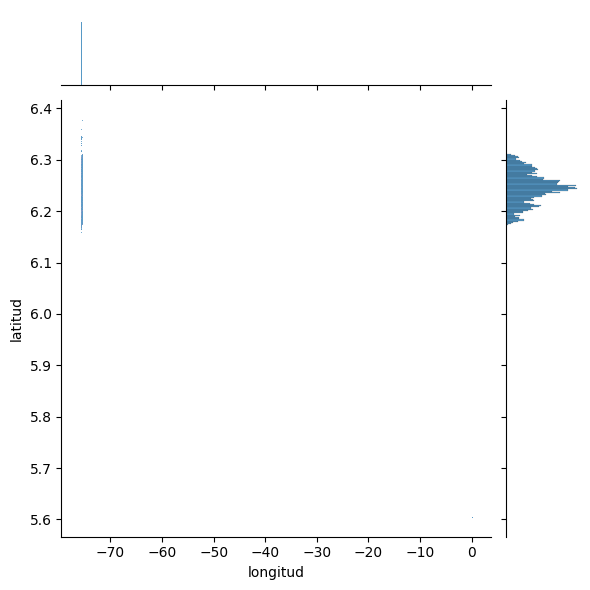

In [5]:
# Generate scatter plot
sns.jointplot(x="longitud", y="latitud", data=db, s=0.5)

In [6]:
db[['longitud', 'latitud']].describe()

longitud       latitud
count  38343.000000  38343.000000
mean     -75.571624      6.245523
std        0.863400      0.031136
min      -75.709227      5.605000
25%      -75.599618      6.226033
50%      -75.583442      6.246407
75%      -75.561705      6.265323
max       -0.000679      6.377163

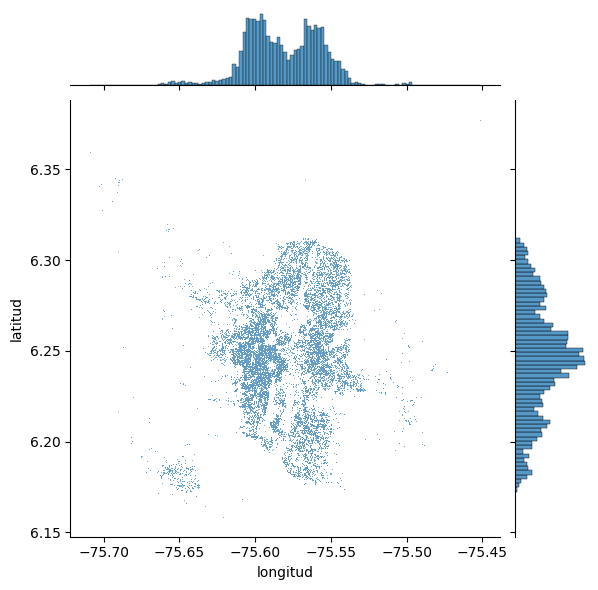

In [7]:
# Generate scatter plot
sns.jointplot(x="longitud", y="latitud", data=db[db['longitud']<-50], s=0.5)

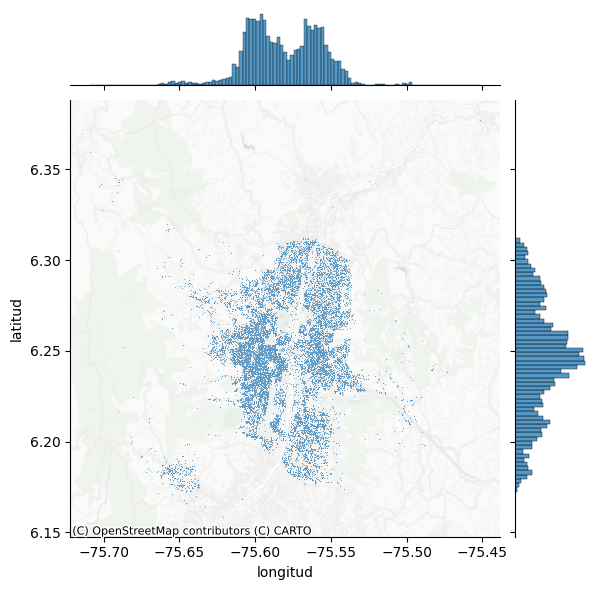

In [8]:
# Generate scatter plot
joint_axes = sns.jointplot(
    x="longitud", y="latitud", data=db[db['longitud']<-50], s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
)

In [9]:
db=db[db['longitud']<-50].copy()

## Visualización de la densidad con hexbinning

Aquí, generamos una cuadrícula regular (ya sea cuadrada o hexagonal), contamos cuántos puntos caen dentro de cada celda y la presentamos como cualquier otro mapa coroplético. Si la cuadrícula regular es lo suficientemente fina, elimina algunas de las distorsiones de área que pueden inducir los mapas coropléticos.

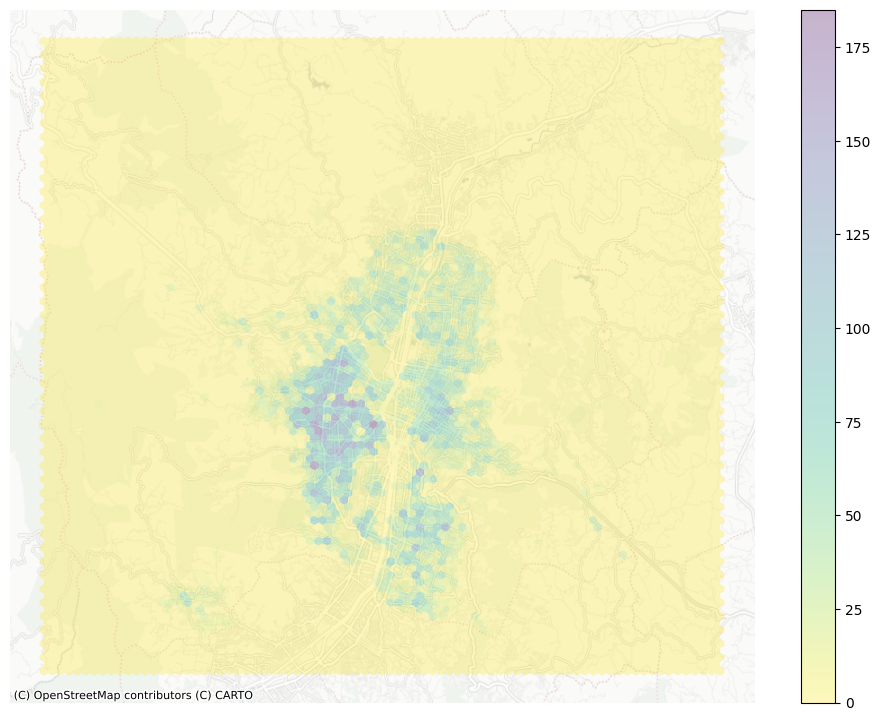

In [10]:
# Convertir a GeoDataFrame y reproyectar
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857) ## Los mapas base de contextily usan EPSG:3857

# Crear figura
f, ax = plt.subplots(1, figsize=(12, 9))

# Hexbin
hb = ax.hexbin(
    gdf.geometry.x,
    gdf.geometry.y,
    gridsize=80, # Divide el ancho total del mapa (mín_x → máx_x) en 80 columnas de hexágonos 
    linewidths=0,
    alpha=0.3,
    cmap="viridis_r",
)

# Basemap en el mismo axis
contextily.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=contextily.providers.CartoDB.PositronNoLabels,
)

# Colorbar
plt.colorbar(hb, ax=ax)

# Quitar ejes
ax.set_axis_off()

plt.show()

## Estimación de densidad kernel
Un KDE 2D genera una “superficie” de densidad, y Seaborn la representa visualmente mediante contornos y rellenos tipo isodensidad (Línea o superficie que conecta puntos con la MISMA densidad).

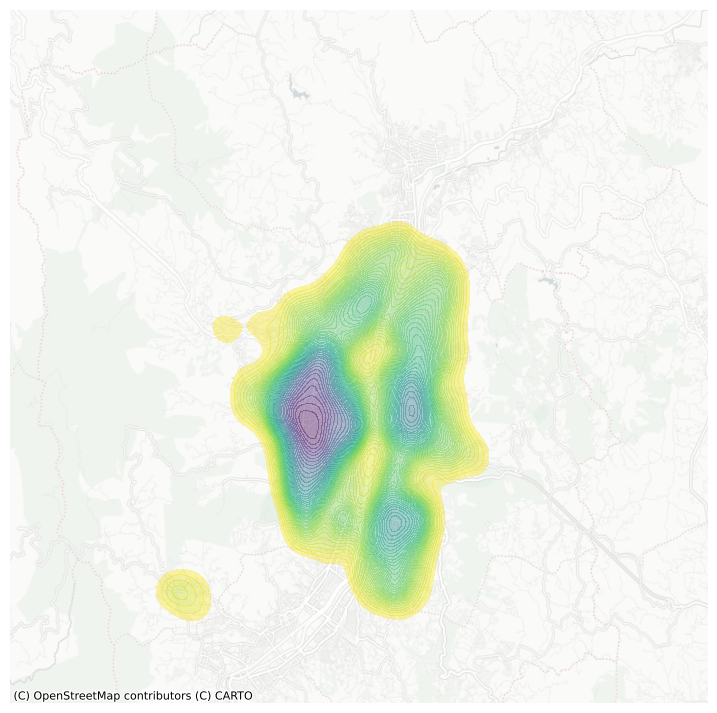

In [11]:
# Convertir a GeoDataFrame y reproyectar
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Estimación de densidad kernel
f, ax = plt.subplots(1, figsize=(9, 9))
sns.kdeplot(
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    data=db,
    n_levels=50, # Define cuántas curvas de nivel de densidad 
    fill=True,
    alpha=0.4,
    cmap="viridis_r",
)
# Add basemap
# Basemap en el mismo axis
contextily.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Remove axes
ax.set_axis_off()

## Centrografía
La centrografía es el análisis de la centralidad en un patrón de puntos. Por "centralidad" entendemos la ubicación general y la dispersión del patrón.

### Tendencia 
Una medida común de tendencia central para un patrón de puntos es su centro de masa. Para patrones de puntos marcados, el centro de masa identifica un punto central cercano a las observaciones con valores más altos en el atributo marcado. Para patrones de puntos no marcados, el centro de masa equivale al centro medio, o promedio de los valores de las coordenadas.

In [12]:
mean_center = centrography.mean_center(db[["longitud", "latitud"]])
med_center = centrography.euclidean_median(db[["longitud", "latitud"]])

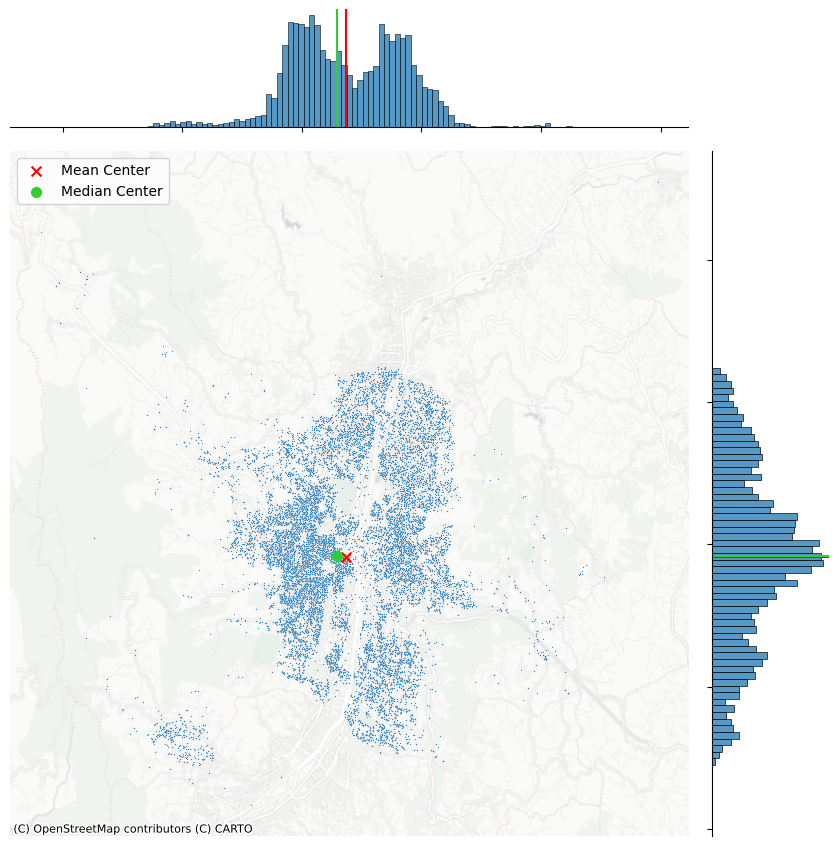

In [13]:
# Generate scatterplot
joint_axes = sns.jointplot(
    x="longitud", y="latitud", data=db, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

### Dispersión
Una medida de dispersión común en centrografía es la distancia estándar . Esta medida proporciona la distancia promedio al centro de la nube de puntos (medida, por ejemplo, por el centro de masa).

In [14]:
# Dispersión estandar en grados
centrography.std_distance(db[["longitud", "latitud"]])

0.039215422077184384

In [15]:
# teniendo en cuenta que 1 grado es aproximadamente 101 km
centrography.std_distance(db[["longitud", "latitud"]]) * 101


3.960757629795623

### Elipse de desviación estándar
Resume la forma, orientación y dispersión de un conjunto de puntos en dos dimensiones. Se define mediante tres parámetros:

- **Semieje mayor (major):** desviación estándar máxima, asociada a la 
  dirección de mayor dispersión. Se obtiene como la raíz cuadrada del 
  mayor autovalor de la matriz de covarianza.

- **Semieje menor (minor):** desviación estándar mínima, perpendicular 
  al eje mayor. Es la raíz del menor autovalor.

- **Rotación (θ):** orientación del eje mayor, calculada a partir del 
  autovector principal como θ = $arctan2(v_y, v_x)$.

El centro de la elipse coincide con el centro medio del conjunto. La SDE 
permite identificar dirección dominante, dispersión espacial y forma del 
fenómeno analizado. 

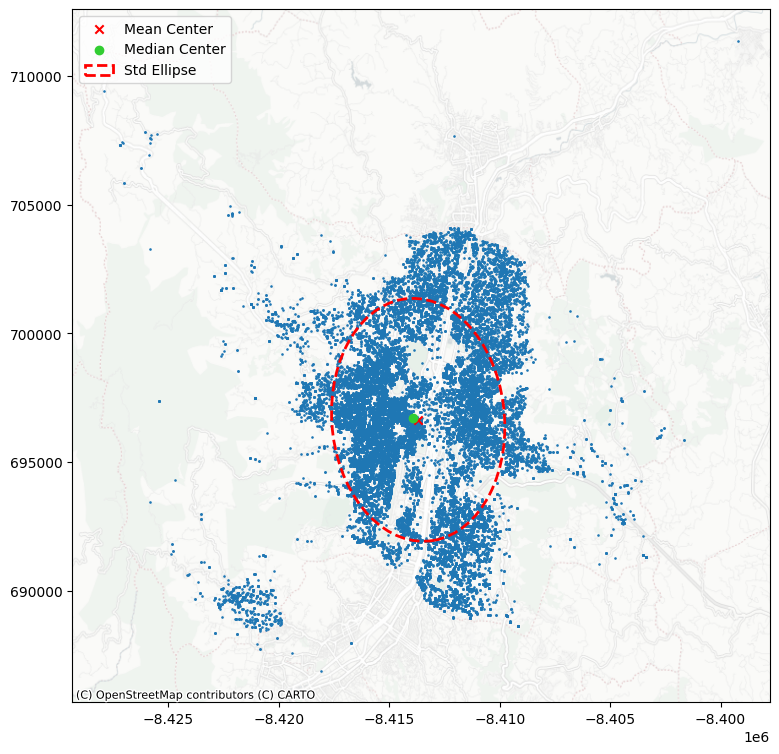

In [16]:
# 1. Crear GeoDataFrame y reproyectar
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(3857)

# Extraer coordenadas en 3857
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y

# 2. Recalcular mean y median center en metros
mean_center = (gdf["x"].mean(), gdf["y"].mean())
med_center  = (gdf["x"].median(), gdf["y"].median())

# 3. Elipse de desviación estándar EN 3857
major, minor, rotation = centrography.ellipse(gdf[["x", "y"]])

# 4. Graficar
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(gdf["x"], gdf["y"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(*med_center, color="limegreen", marker="o", label="Median Center")

# Construir elipse correctamente proyectada
ellipse = Ellipse(
    xy=mean_center,
    width=major * 2,
    height=minor * 2,
    angle=np.degrees(rotation),
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    linewidth=2,
    label="Std Ellipse"
)

ax.add_patch(ellipse)
ax.legend()

# 5. Basemap correcto
contextily.add_basemap(
    ax,
    crs="EPSG:3857",
    source=contextily.providers.CartoDB.PositronNoLabels
)

plt.show()

### Envolvente convexa y Alpha Shape

- La envolvente convexa es el polígono convexo más pequeño que contiene a todos los puntos de un conjunto. 
- El Alpha Shape es una generalización del Convex Hull que permite obtener un contorno cóncavo, capaz de capturar la forma real del conjunto de puntos. Utiliza un parámetro α para controlar la curvatura del borde.
- Los círculos alpha son los círculos vacíos utilizados para determinar el contorno del Alpha Shape. Un círculo alpha es un círculo de radio ≤ α que toca dos o tres puntos del conjunto sin contener otros puntos en su interior.

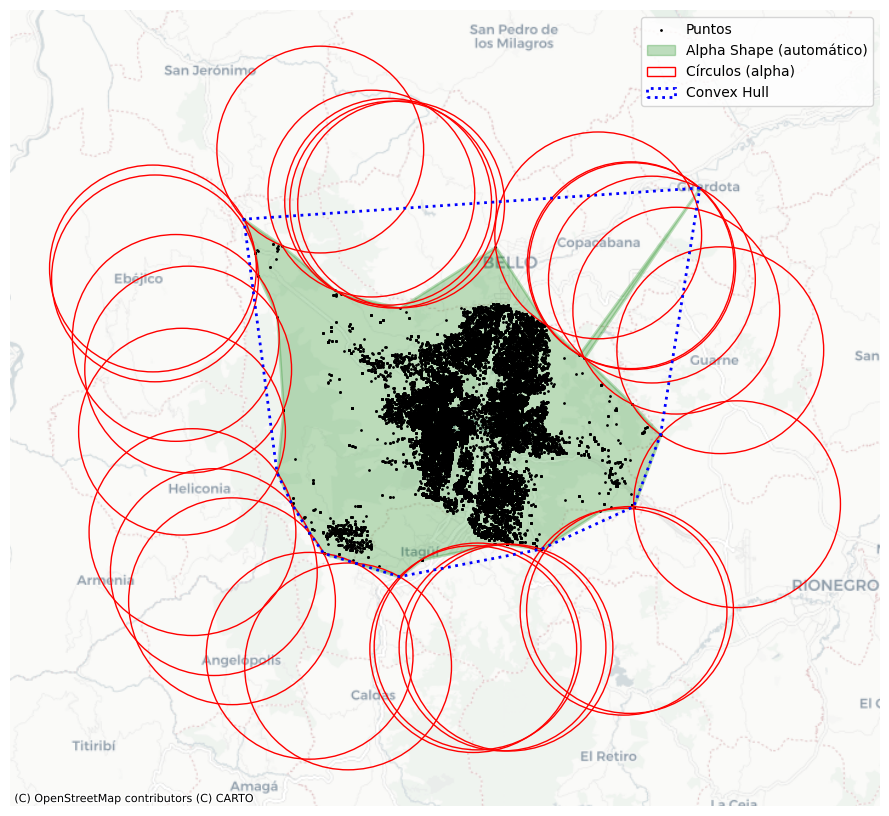

In [17]:
# ==============================
# 1. Convertir a GeoDataFrame y reproyectar
# ==============================
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(3857)

# Extraer coordenadas (Nx2)
coordinates = np.column_stack([gdf.geometry.x, gdf.geometry.y])

# ==============================
# 2. Envolvente convexa
# ==============================
convex_hull_vertices = centrography.hull(coordinates)

# ==============================
# 3. Alpha Shape (automático)
# ==============================
alpha_shape, alpha, circs = cg.alpha_shape_auto(
    coordinates, return_circles=True
)

# ==============================
# 4. Graficar todo
# ==============================
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# --- 4.1 Alpha Shape (verde) ---
gpd.GeoSeries([alpha_shape]).plot(
    ax=ax,
    edgecolor="green",
    facecolor="green",
    alpha=0.25,
    linewidth=2
)

# proxy artist para la leyenda
alpha_proxy = patches.Patch(
    facecolor="green",
    edgecolor="green",
    alpha=0.25,
    label="Alpha Shape (automático)"
)

# --- 4.2 Puntos originales ---
points_plot = ax.scatter(
    coordinates[:, 0], coordinates[:, 1],
    color="black", s=1,
    label="Puntos"
)

# --- 4.3 Círculos generadores (rojos) ---
circle_handles = []
for i, circle in enumerate(circs):
    h = plt.Circle(
        circle, radius=alpha,
        facecolor="none",
        edgecolor="red",
        linewidth=1
    )
    ax.add_patch(h)
    if i == 0:  # solo añadimos uno a la leyenda
        circle_handles.append(
            patches.Patch(facecolor="none", edgecolor="red", label="Círculos (alpha)")
        )

# --- 4.4 Convex Hull (azul punteado) ---
hull_patch = patches.Polygon(
    convex_hull_vertices,
    closed=True,
    edgecolor="blue",
    facecolor="none",
    linestyle=":",
    linewidth=2,
    label="Convex Hull"
)
ax.add_patch(hull_patch)

# ==============================
# 5. Basemap
# ==============================
contextily.add_basemap(
    ax,
    crs="EPSG:3857",
    source=contextily.providers.CartoDB.Positron
)

# ==============================
# 6. LEYENDA (con todos los proxies)
# ==============================
handles = [
    points_plot,
    alpha_proxy,
    circle_handles[0],
    hull_patch,
]

ax.legend(handles=handles, loc="upper right")

# ==============================
# 7. Ajustes finales
# ==============================
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Aleatoriedad y agrupamiento

La estadística espacial sobre patrones de puntos suele analizar la uniformidad de la distribución de puntos. Con esto, nos referimos a si los puntos tienden a agruparse cerca unos de otros o a dispersarse uniformemente por toda el área del problema.

### Puntos de Poisson
Puntos generados aleatoriamente, como se veria? (como es un proceso totalmente aleatirio no hay agrupamiento ni dispersión)

In [19]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

In [20]:
random_pattern = random.poisson(coordinates, size=len(coordinates))

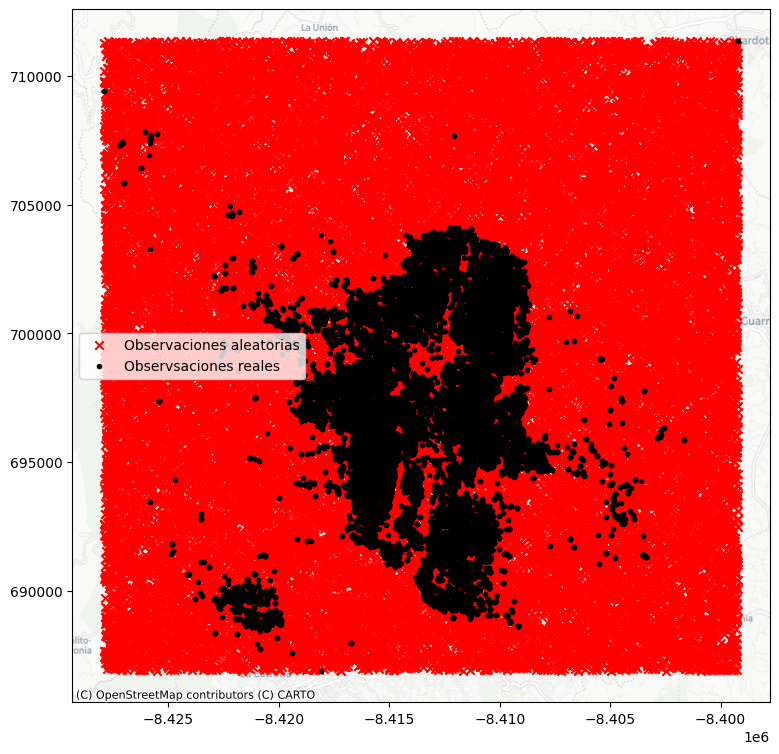

In [22]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.scatter(*random_pattern.T, color="r", marker="x", label="Observaciones aleatorias")
plt.scatter(
    *coordinates.T,
    color="k",
    marker=".",
    label="Observsaciones reales"
)
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="center left")
plt.show()

In [23]:
# Patron aleatorio basado en alpha shape
random_pattern_ashape = random.poisson(
    alpha_shape, size=len(coordinates)
)

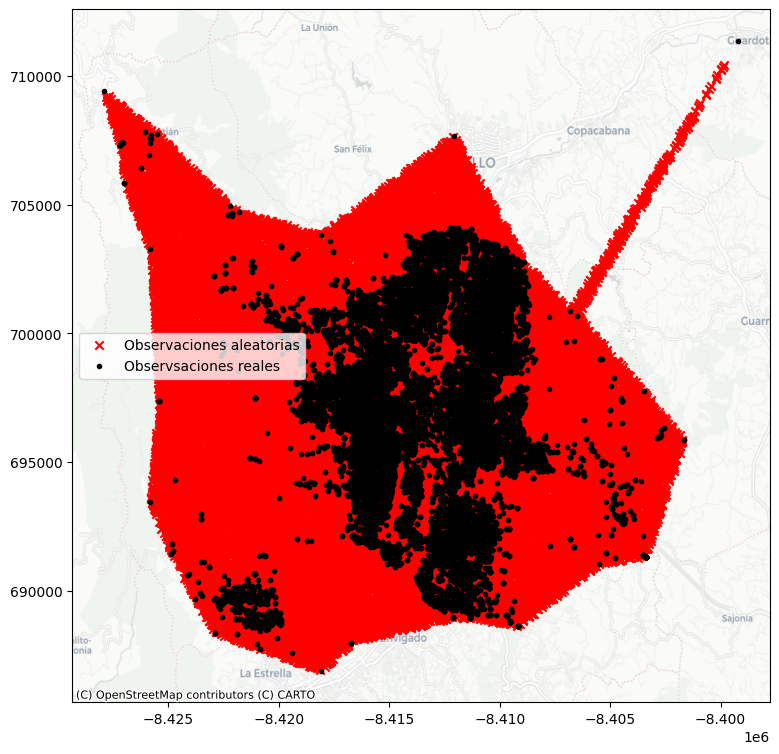

In [24]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(
    *random_pattern_ashape.T, color="r", marker="x", label="Observaciones aleatorias"
)
plt.scatter(*coordinates.T, color="k", marker=".", label="Observsaciones reales")

contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="center left")
plt.show()

### Estadísticas de cuadrantes
La estadística de cuadrantes examina la distribución espacial de los puntos en un área en términos del número de observaciones que caen dentro de una celda dada. Al examinar si las observaciones se distribuyen uniformemente entre las celdas, el enfoque de cuadrantes busca estimar si los puntos están dispersos o agrupados en unas pocas celdas. En sentido estricto, la estadística de cuadrantes examina la uniformidad de la distribución entre las celdas mediante la prueba estadística $ \chi^2 $ (prueba estadística para determinar si hay una asociación significativa entre  variables categóricas/cualitativas. En este caso la hipotesis nula es que las celdas no son diferentes, es decir, existe una distribución uniforme de las observaciones).

¿La intensidad de puntos es constante en todos los cuadrantes, como se espera bajo un proceso espacial completamente aleatorio (CSR)?

Si se rechaza la hipotesis nula: hay evidencia de agregación (clustering) o dispersión. 

Estamos evaluando si las frecuencias observadas por cuadrante coinciden con las frecuencias esperadas bajo una probabilidad uniforme proporcional al área.

<Axes: title={'center': 'Quadrat Count'}>

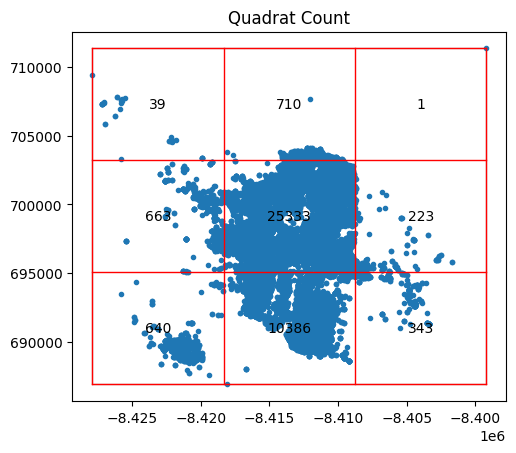

In [25]:
qstat = QStatistic(coordinates)
qstat.plot()

In [26]:
qstat.chi2_pvalue

0.0

<Axes: title={'center': 'Quadrat Count'}>

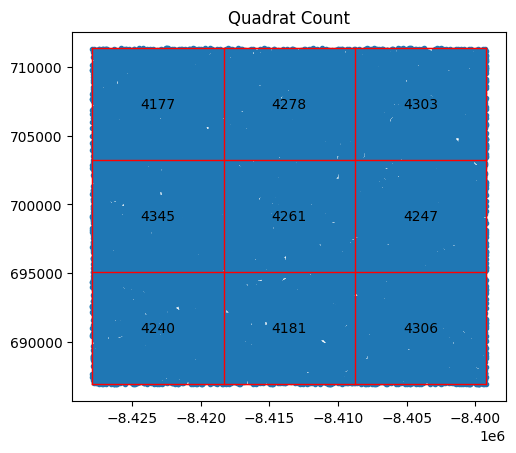

In [27]:
qstat_null = QStatistic(random_pattern)
qstat_null.plot()

In [31]:
# Estadistico para un patrón aleatorio (un valor cercano a 1 significa no significativo)
qstat_null.chi2_pvalue

0.6563065665323087

<Axes: title={'center': 'Quadrat Count'}>

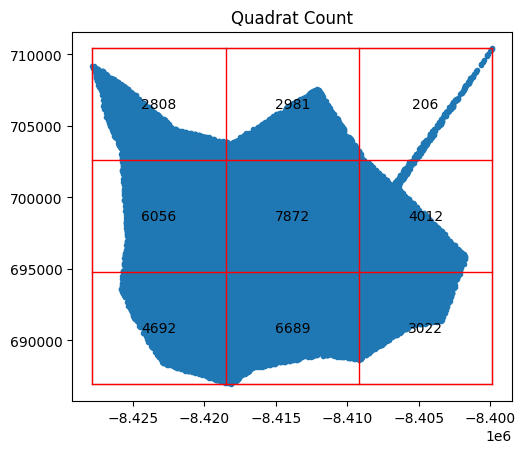

In [32]:
qstat_null_ashape = QStatistic(random_pattern_ashape)
qstat_null_ashape.plot()

In [33]:
qstat_null_ashape.chi2_pvalue

0.0